In [62]:
# loading latent data
import numpy as np
import matplotlib.pyplot as plt

SFH_data = np.load('Latent data/latentdata.npy')
mass_sfr = np.load('Latent data/masspresentsfr.npy')

In [63]:
mass_sfr.shape, SFH_data.shape

((63110, 2), (63110, 16))

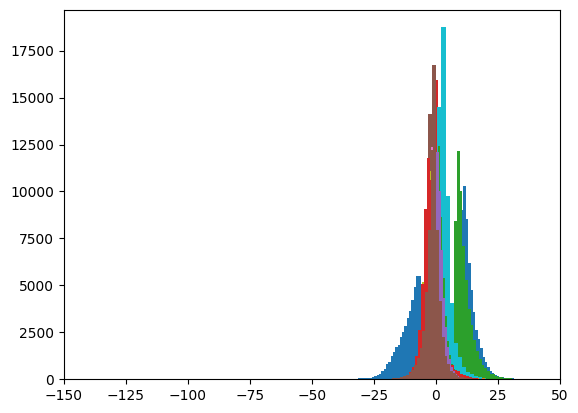

In [64]:
for i in range(16):
    plt.hist(SFH_data.T[i], bins=100)
    plt.xlim(-150, 50)

In [51]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(SFH_data, mass_sfr, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [52]:
device = torch.device("mps")

In [65]:
# Building an MLP model
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(16, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [66]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [67]:
# Training loop
num_epochs = 300
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        curr_loss = criterion(outputs, targets)
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)


    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training complete')

Epoch [10/300], Training Loss: 0.3208, Val Loss: 0.3036
Epoch [20/300], Training Loss: 0.3028, Val Loss: 0.3074
Epoch [30/300], Training Loss: 0.3010, Val Loss: 0.2914
Epoch [40/300], Training Loss: 0.3002, Val Loss: 0.2928
Epoch [50/300], Training Loss: 0.2986, Val Loss: 0.3047
Epoch [60/300], Training Loss: 0.2990, Val Loss: 0.2974
Epoch [70/300], Training Loss: 0.2961, Val Loss: 0.2867
Epoch [80/300], Training Loss: 0.2906, Val Loss: 0.2906
Epoch [90/300], Training Loss: 0.2896, Val Loss: 0.2837
Epoch [100/300], Training Loss: 0.2908, Val Loss: 0.2906
Epoch [110/300], Training Loss: 0.2866, Val Loss: 0.2918
Epoch [120/300], Training Loss: 0.2848, Val Loss: 0.2856
Epoch [130/300], Training Loss: 0.2823, Val Loss: 0.2861
Epoch [140/300], Training Loss: 0.2802, Val Loss: 0.2908
Epoch [150/300], Training Loss: 0.2784, Val Loss: 0.2891
Epoch [160/300], Training Loss: 0.2801, Val Loss: 0.2869
Epoch [170/300], Training Loss: 0.2766, Val Loss: 0.2880
Epoch [180/300], Training Loss: 0.2772, 

(0.0, 1.0)

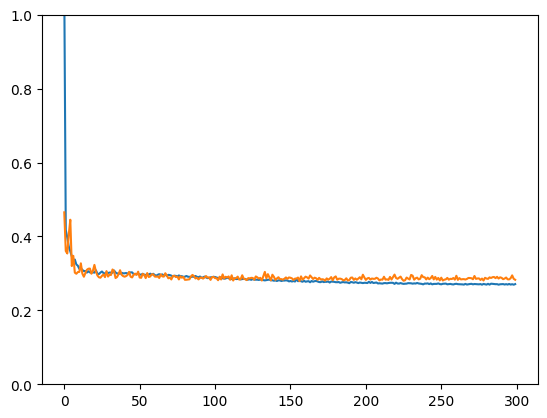

In [68]:
plt.plot(losses)
plt.plot(val_losses)
plt.ylim(0, 1)

In [69]:
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.unsqueeze(1).to(device))

y_pred = y_pred_tensor.cpu()

In [70]:
pred_mass = y_pred.T[0].flatten()
pred_sfr = y_pred.T[1].flatten()

In [71]:
pred_mass.shape, pred_sfr.shape

(torch.Size([6311]), torch.Size([6311]))

In [72]:
stellar_mass = y_test_tensor.T[0]
star_formation_rate = y_test_tensor.T[1]

Score for log stellar mass: 0.4025421142578125
Score for arcsinh SFR: 0.2333657145500183

RMSE for Stellar Mass: 0.4870671331882477 
RMSE for SFR: 0.5891619920730591

Baseline RMSE for Stellar Mass: 0.6301372647285461 (Predicting the mean) 
Baseline RMSE for SFR: 0.6728845834732056 (Predicting the mean)

1,5,10,50,90,95,99 Percentiles for mass residuals: [-1.28366308 -0.87870312 -0.68072224  0.01034451  0.52938461  0.66060829
  1.02403746]

1,5,10,50,90,95,99 Percentiles for SFR residuals: [-2.03323219 -1.32239228 -0.87266833  0.06146708  0.49197286  0.62403002
  0.90270182]


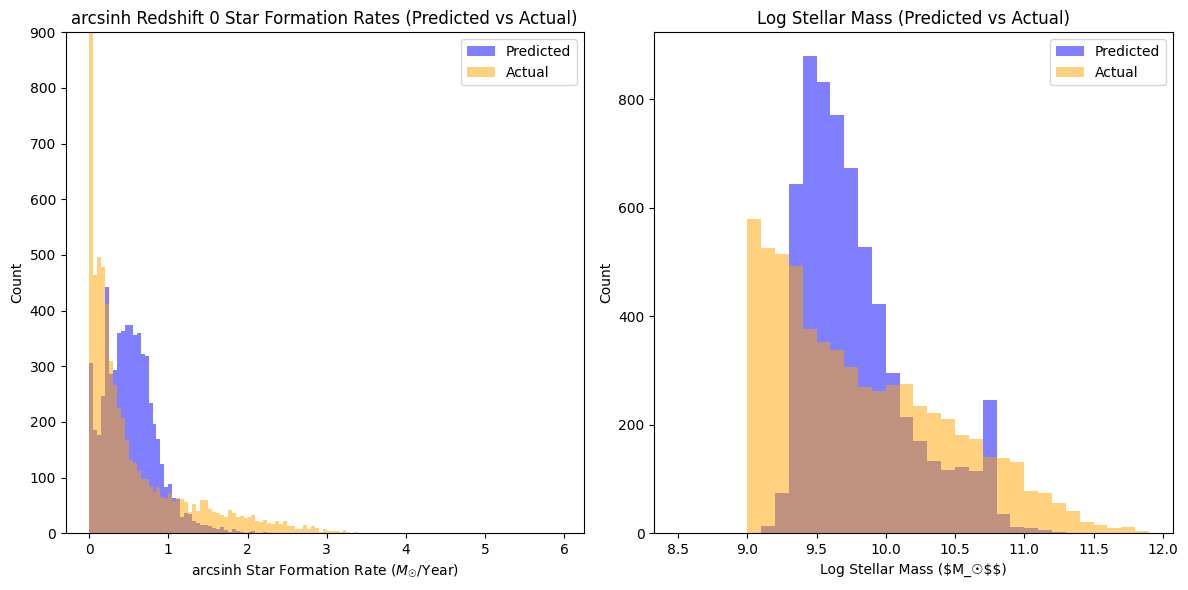

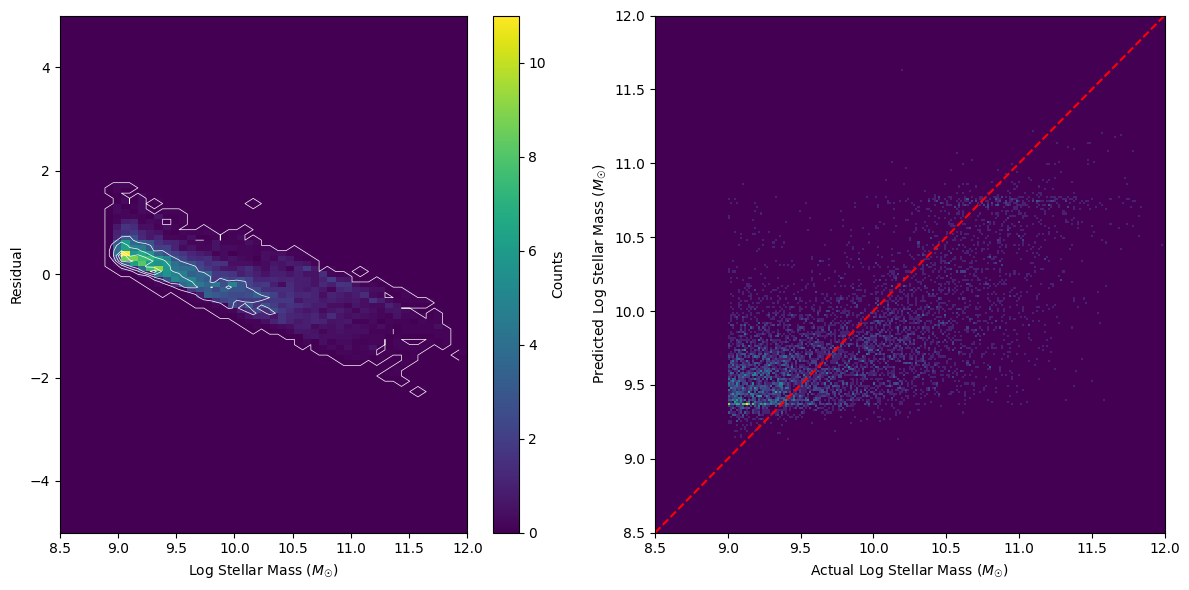

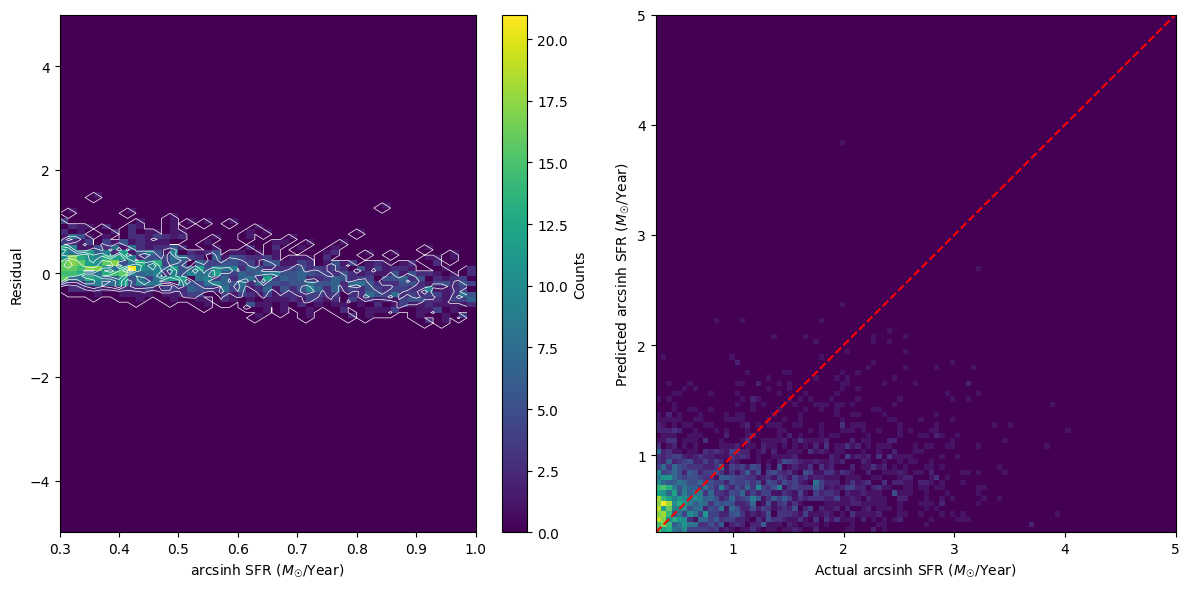

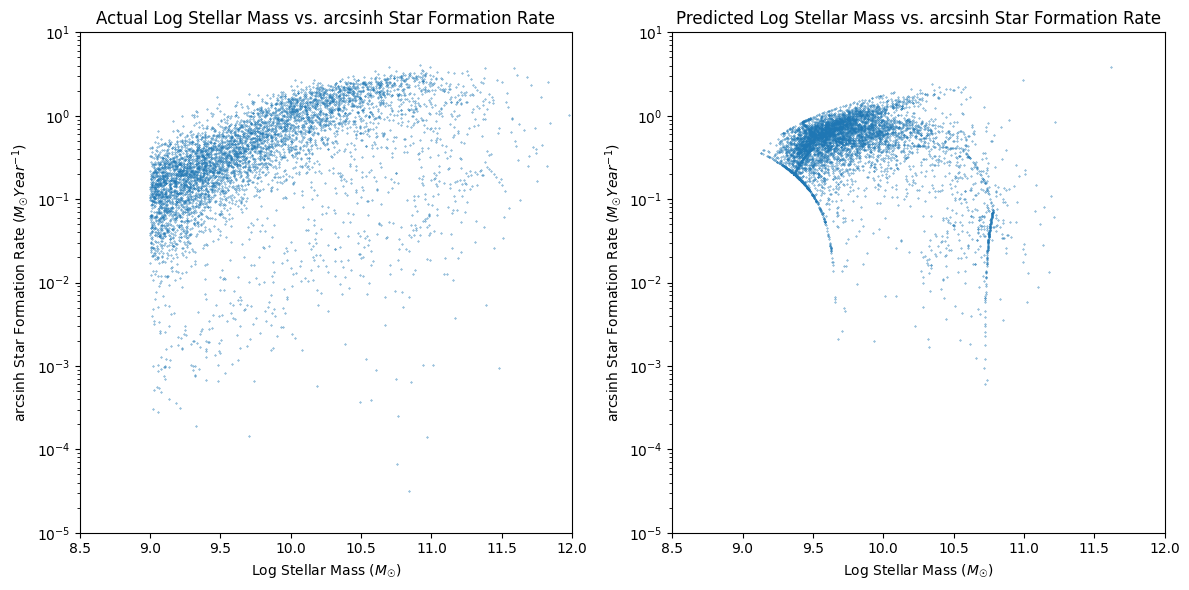

In [73]:
from DataEval import pred_actual_data_eval, pred_actual_data_vis
pred_actual_data_eval(pred_mass, pred_sfr, stellar_mass, star_formation_rate)
pred_actual_data_vis(pred_mass, pred_sfr, stellar_mass, star_formation_rate)

In [52]:
# test model accuracy
test_outputs = model(torch.tensor(X_test).to(device))

In [36]:
test_outputs_categorical = np.zeros(test_outputs.shape)
for i in range(len(test_outputs)):
    _, indices = torch.max(test_outputs[i], 0)    
    predicted_label = indices.item()
    test_outputs_categorical[i][predicted_label] = 1

Text(0.5, 1.0, 'Confusion Matrix: SFH, 0,695 Accuracy')

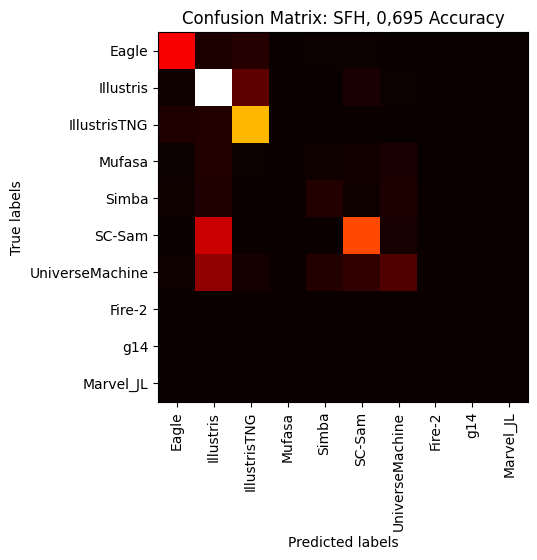

In [39]:
confusion_matrix = np.zeros((10, 10))
for i in range(len(y_test)):
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(test_outputs_categorical[i])
    confusion_matrix[true_label][predicted_label] += 1

plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
# Labelling the simulation names

sim_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel_JL']
plt.xticks(np.arange(10), sim_names, rotation=90)
plt.yticks(np.arange(10), sim_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: SFH, 0,695 Accuracy')

In [37]:
# Printing the confusion matrix without scientific notation
np.set_printoptions(suppress=True)
print(confusion_matrix)

[[ 618.   17.   73.    5.    0.    8.   10.    0.    0.    0.]
 [  27. 1735.   58.   12.    0.   90.   46.    0.    0.    0.]
 [  21.   74. 1078.    7.    1.    5.    7.    0.    0.    0.]
 [   9.   17.    6.   48.   40.   14.   35.    0.    0.    0.]
 [   8.    7.    9.   25.  107.   11.   33.    0.    0.    0.]
 [   6.   75.    6.    8.    7. 1160.   62.    0.    0.    0.]
 [   7.   65.   13.   44.   41.  100.  454.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    1.    0.    0.    0.    1.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


In [38]:
# calculate accuracy
correct = 0
for i in range(len(y_test)):
    if np.array_equal(y_test[i], test_outputs_categorical[i]):
        correct += 1

print(correct / len(y_test))

0.6952939312311837
